# Exercise 2.05

In [1]:
import tensorflow as tf
import os

In [2]:
def load_audio(file_path, sample_rate=44100):
    # Load audio at 44.1kHz sample-rate
    audio = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio,
                                             desired_channels=-1,
                                             desired_samples=sample_rate)
    return tf.transpose(audio)

In [3]:
prefix = "../Datasets/data_speech_commands_v0.02/zero/"
paths = [os.path.join(prefix, path) for path in os.listdir(prefix)]

2021-10-07 10:22:15.130872: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Text(0, 0.5, 'Value')

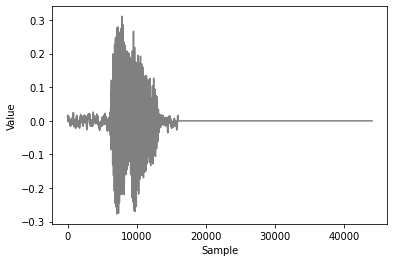

In [4]:
import matplotlib.pyplot as plt
audio = load_audio(paths[0])
plt.plot(audio.numpy().T, color='grey')
plt.xlabel('Sample')
plt.ylabel('Value')

In [5]:
def apply_mfccs(audio, sample_rate=44100, num_mfccs=13):
    stfts = tf.signal.stft(audio, frame_length=1024, frame_step=256, fft_length=1024)
    spectrograms = tf.abs(stfts)
    spectrogram_bins = stfts.shape[-1]

    lower_bound, upper_bound, mel_bins = 80.0, 7600.0, 80
    # create linear to mel weight matrix
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
          mel_bins, spectrogram_bins, 
          sample_rate, lower_bound, upper_bound)
    # take tensor product of spectrograms and weight matrix
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    # reshape mel spectrograms
    mel_spectrograms.set_shape(\
      spectrograms.shape[:-1].concatenate(\
      linear_to_mel_weight_matrix.shape[-1:]))

    # add 1e-6 to prevent log errors and take the log
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    #compute MFCCs from log_mel_spectrograms
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mfccs]
    return mfccs

Text(0, 0.5, 'Sample Value')

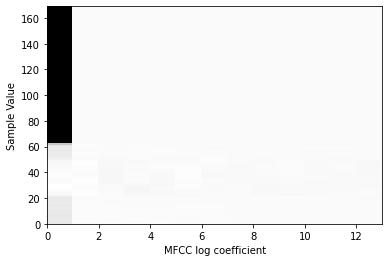

In [6]:
mfcc = apply_mfccs(audio)
plt.pcolor(mfcc.numpy()[0], cmap='Greys_r')
plt.xlabel('MFCC log coefficient')
plt.ylabel('Sample Value')

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prep_ds(ds, shuffle_buffer_size=1024, batch_size=64):
    # Randomly shuffle (file_path, label) dataset
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # Load and decode audio from file paths
    ds = ds.map(load_audio, num_parallel_calls=AUTOTUNE)
    # generayte MFCCs from the audio data
    ds = ds.map(apply_mfccs)
    # Repeat dataset forever
    ds = ds.repeat()
    # Prepare batches
    ds = ds.batch(batch_size)
    # Prefetch
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [8]:
ds = tf.data.Dataset.from_tensor_slices(paths)
train_ds = prep_ds(ds)

Take 1 batch and print it out

In [9]:
for x in train_ds.take(1):
    print(x)

2021-10-07 10:22:23.182352: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


tf.Tensor(
[[[[-6.6339531e+01 -1.2424583e+00  1.3780766e+00 ...  3.7099034e-01
    -1.3867416e+00 -1.3363682e+00]
   [-6.2325153e+01  7.5530821e-01  2.3440952e+00 ...  1.5556949e-01
    -1.2651505e+00 -1.3503013e+00]
   [-6.0770931e+01  1.7311867e+00  2.5881791e+00 ... -1.3085013e-02
    -7.4027431e-01 -5.8740962e-01]
   ...
   [-1.7475427e+02 -7.8259567e-05  8.2965726e-06 ...  8.8049037e-06
     6.4839332e-06 -2.2959596e-06]
   [-1.7475427e+02 -7.8259567e-05  8.2965726e-06 ...  8.8049037e-06
     6.4839332e-06 -2.2959596e-06]
   [-1.7475427e+02 -7.8259567e-05  8.2965726e-06 ...  8.8049037e-06
     6.4839332e-06 -2.2959596e-06]]]


 [[[-3.4494122e+01  7.8220379e-01  2.2117560e+00 ...  5.3742164e-01
     1.2497974e-01  1.0344307e-01]
   [-3.3686043e+01  1.4708641e+00  2.9195912e+00 ... -1.1412978e-02
    -1.5695088e-01  5.8146775e-01]
   [-3.2439842e+01  1.9294703e+00  3.5649185e+00 ...  6.8191618e-01
    -8.1257480e-01 -4.4441494e-01]
   ...
   [-1.7475427e+02 -7.8259567e-05  8.2965726